# CCD characterization lab
### AST6725C Observational Techniques

## Setting up notebook

In [728]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from glob import glob
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit

In [551]:
# tell me I'm pretty
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.family'] = "serif"
plt.rcParams["errorbar.capsize"] = 5

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rcParams['mathtext.fontset'] = 'dejavuserif'

plt.rcParams.update(params)
plt.rc('font',**{'family':'serif','sans-serif':['Times']})
sns.set_style("ticks")
plt.rcParams['font.family'] = "serif"

## Creating a master bias frame

### We take multiple short (~0.1s) dark exposures that we can median-combine to obtain a "master bias" that characterizes the noise floor of CCD and can be subtracted from the dark exposures when we calculate dark current later

In [552]:
# import bias frames and stack into an array
bias_files = glob('day1/01s_darks/darkz*.fits') #day1/bias*.fits')
bias_images = []
bias_medians = []
for i in range(len(bias_files)):
    bias_images.append(fits.getdata(bias_files[i]))
    bias_medians.append(np.median(bias_images[i]))
bias_image_array = np.array(bias_images)

# median combine bias array into a master bias frame
master_bias = np.median(bias_image_array, axis=0)

In [553]:
# check the median of the bias frames recorded during dark current measurement-- does it drift?
for i in range(len(bias_files)):
    print('Median bias level =     ', bias_medians[i], ' +- ', np.std(bias_images[i]))

# median of master bias frame
print('Median of master bias = ', np.median(master_bias), ' +- ', np.std(master_bias))

Median bias level =      1037.0  +-  28.28592773705409
Median bias level =      1035.0  +-  28.283811788677113
Median bias level =      1034.0  +-  28.167121490894747
Median bias level =      1038.0  +-  28.65169989169404
Median bias level =      1034.0  +-  28.174172231698293
Median bias level =      1034.0  +-  28.192017940433153
Median bias level =      1036.0  +-  28.286479555542865
Median bias level =      1035.0  +-  28.605976029722182
Median bias level =      1038.0  +-  28.162967444923854
Median bias level =      1038.0  +-  28.541281924673598
Median of master bias =  1035.5  +-  11.70530333010772


Text(0.5, 1.0, 'Master bias')

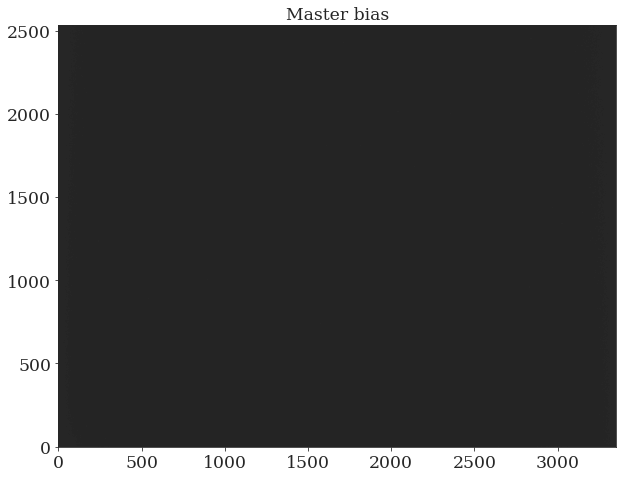

In [558]:
# plot master bias frame to make sure it looks ok
graymin = 2.5
graymax = 6
plt.figure(figsize=(10,10)) 
plt.imshow(np.log10(master_bias), origin='lower', cmap='gray', vmin=graymin, vmax=graymax);
plt.title('Master bias')
#plt.colorbar()

## Read noise as a function of time

### This section is about investigating whether the read noise changes as a function of exposure time

In [171]:
# read in the data

# 0.1-second exposures
read_01s=bias_images

# 1-second exposures
read_1s=[]
read_1s.append(fits.getdata('day1/1s_darks/darkz_1s.2020-09-24T20:26:34.462.0066.fits'))
read_1s.append(fits.getdata('day1/1s_darks/darkz_1s.2020-09-24T20:26:40.053.0067.fits'))
read_1s.append(fits.getdata('day1/1s_darks/darkz_1s.2020-09-24T20:26:46.563.0068.fits'))
read_file_names_10s = glob('day1/10s_darks/*.fits')

# 10-second exposures
read_10s=[]
for i in range(len(read_file_names_10s)):
    read_10s.append(fits.getdata(read_file_names_10s[i]))

In [172]:
# put read noise data into arrays
read_01s = np.array(read_01s)
read_1s = np.array(read_1s)
read_10s = np.array(read_10s)

In [434]:
# just looking at 0.1-second exposures for now, create "RMS array" and look at mean/median/std
read_01s_rms = np.sqrt(np.mean(read_01s**2, axis=0))
print('mean = ', np.mean(read_01s_rms))
print('median = ', np.median(read_01s_rms))
print('std =', np.std(read_01s_rms))

mean =  179.22917828272688
median =  180.01638814285772
std = 16.87047633835987


In [435]:
read_1s_rms = np.sqrt(np.mean(read_1s**2, axis=0))
print('mean = ', np.mean(read_1s_rms))
print('median = ', np.median(read_1s_rms))
print('std =', np.std(read_1s_rms))

mean =  177.23594379429056
median =  180.04721602957375
std = 32.04059740121784


In [438]:
read_10s_rms = np.sqrt(np.mean(read_10s**2, axis=0))
print('mean = ', np.mean(read_10s_rms))
print('median = ', np.median(read_10s_rms))
print('std =', np.std(read_10s_rms))

mean =  177.20567331338276
median =  180.03240449059905
std = 32.07795185085348


### Now we create a histogram and fit a Gaussian to the binned data

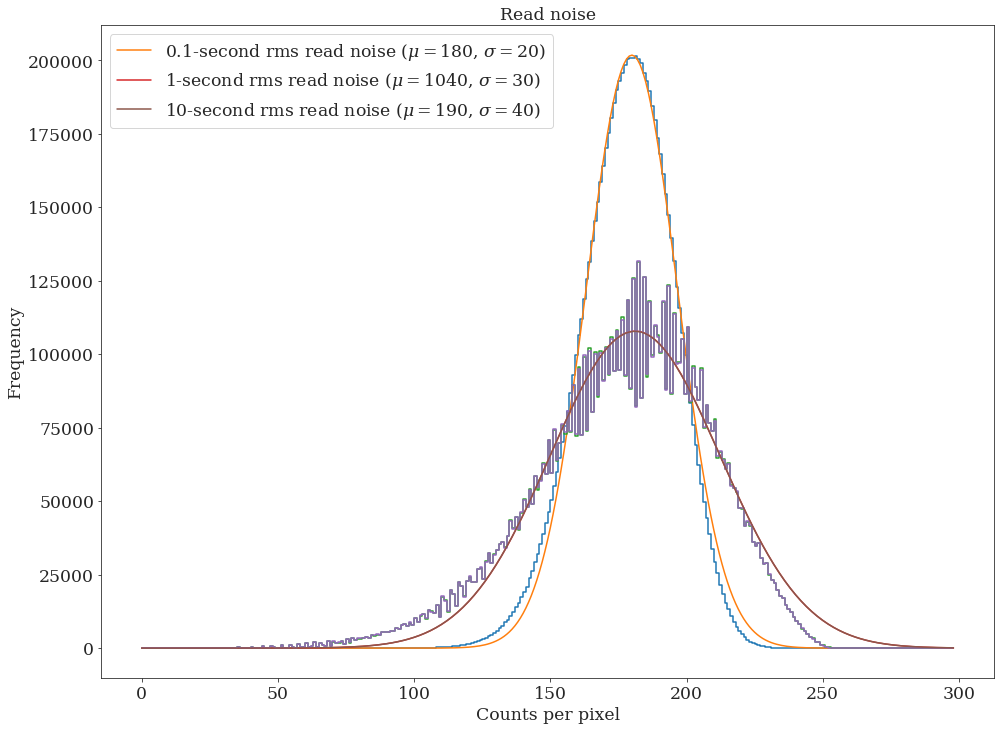

In [524]:
counts, bins = np.histogram(1.0*read_01s_rms.ravel(), bins=np.arange(0, 300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(read_01s_rms),np.std(read_01s_rms)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="0.1-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_01s/10.0))*10, (np.ceil(sigma_01s/10.0))*10))
mu_01s, sigma_01s = popt[1], popt[2]

counts, bins = np.histogram(1.0*read_1s_rms.ravel(), bins=np.arange(0, 300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(read_1s_rms),np.std(read_1s_rms)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="1-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_1s/10.0))*10, (np.ceil(sigma_1s/10.0))*10))
mu_1s, sigma_1s = popt[1], popt[2]

counts, bins = np.histogram(1.0*read_10s_rms.ravel(), bins=np.arange(0, 300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(read_10s_rms),np.std(read_10s_rms)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="10-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_10s/10.0))*10, (np.ceil(sigma_10s/10.0))*10))
mu_10s, sigma_10s = popt[1], popt[2]

plt.title('Read noise')
plt.xlabel("Counts per pixel")
plt.ylabel("Frequency")
plt.legend() #["0.1-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_01s/10.0))*10, (np.ceil(sigma_01s/10.0))*10), "", # rounding to nearest 10
            #"1-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_1s/10.0))*10, (np.ceil(sigma_1s/10.0))*10), "",
            #"10-second rms read noise ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_10s/10.0))*10, (np.ceil(sigma_10s/10.0))*10), ""])
plt.savefig('read_noise.png')

### Looking at the difference image between pairs of bias frames gives us a better idea of the fluctuations within individual pixels, rather than systematic variations among different pixels:

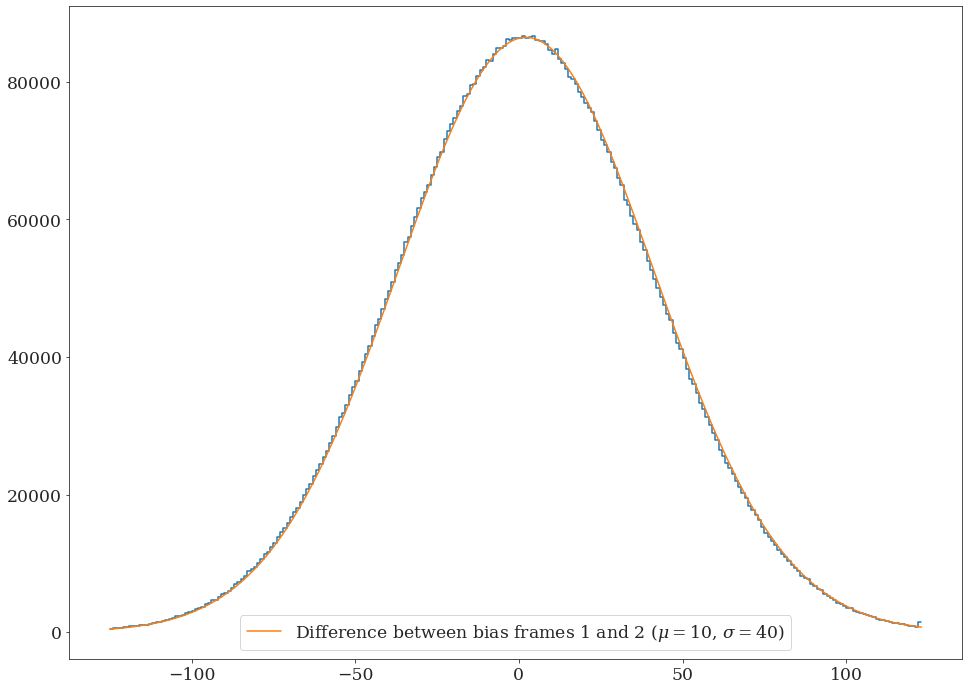

In [547]:
# compare two different bias frames
diff = (1.0*np.array(read_01s[0]) - 1.0*np.array(read_01s[1]))
np.shape(diff)

counts, bins = np.histogram(1.0*diff.ravel(), bins=np.arange(-125, 125, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(diff),np.std(diff)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
mu, sigma = popt[1], popt[2]
plt.plot(bins[:-1], fit, label="Difference between bias frames 1 and 2 ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu/10.0))*10, (np.ceil(sigma/10.0))*10))
plt.legend()

## Measuring dark current

### Our dark frames contain noise from the bias as well as the dark current. We have to de-bias the images in order to evaluate the dark current at ~0°C

In [20]:
# get the dark exposures: 1s, 5s, 25s, 125s, 500s
dark_1s = fits.getdata('day1/1s_darks/darkz_1s_2.2020-09-24T20:33:53.984.0074.fits')
dark_5s = fits.getdata('day1/5s_darks/darkz_5s.2020-09-24T20:34:40.015.0076.fits')
dark_25s = fits.getdata('day1/25s_darks/darkz_25s.2020-09-24T20:36:22.117.0078.fits')
dark_125s = fits.getdata('day1/125s_darks/darkz_125s.2020-09-24T20:39:17.338.0080.fits')
dark_500s = fits.getdata('day1/500s_darks/darkz_500s.2020-09-24T20:48:52.067.0082.fits')

### We took additional bias frames between each dark exposure to evaluate whether the bias level was drifting

In [154]:
# import interstitial bias frames and stack into an array
bias_drift_files = glob('day1/bias*.fits')
bias_drift_images = []
bias_drift_medians = []
for i in range(len(bias_drift_files)):
    bias_drift_images.append(fits.getdata(bias_drift_files[i]))
    bias_drift_medians.append(np.median(bias_drift_images[i]))
#bias_image_array = np.array(bias_images)

# check the median of the bias frames recorded during dark current measurement-- does it drift?
print('Initial master bias level = ', np.median(master_bias), ' +- ', np.std(master_bias))
for i in range(len(bias_drift_files)):
    print('Median bias level =         ', bias_drift_medians[i], ' +- ', np.std(bias_drift_images[i]))

Initial master bias level =  1035.5  +-  28.28592773705409
Median bias level =          1044.0  +-  28.368267665208595
Median bias level =          1043.0  +-  28.70372039892363
Median bias level =          1047.0  +-  28.764796135626042
Median bias level =          1043.0  +-  28.256870421034566
Median bias level =          1041.0  +-  28.251332841229846
Median bias level =          1047.0  +-  28.709827328307778


### The median bias level was not drifting significantly

### Now we can de-bias the dark exposures to remove the readout noise and be left with dark current (as well as bad pixels and cosmic ray strikes... but I'm not confident about the proper way to deal with those right now)

In [462]:
# debias dark frames
exposure = [1,5,25,125,500]
debias_dark_1s = dark_1s - master_bias
debias_dark_5s = dark_5s - master_bias
debias_dark_25s = dark_25s - master_bias
debias_dark_125s = dark_125s - master_bias
debias_dark_500s = dark_500s - master_bias

# put darks and stds into an array -- BIAS version just to check
darks=[]
darks_std=[]

darks.append(np.median(dark_1s))
darks_std.append(np.std(dark_1s))
darks.append(np.median(dark_5s))
darks_std.append(np.std(dark_5s))
darks.append(np.median(dark_25s))
darks_std.append(np.std(dark_25s))
darks.append(np.median(dark_125s))
darks_std.append(np.std(dark_125s))
darks.append(np.median(dark_500s))
darks_std.append(np.std(dark_500s))

# put darks and stds into an array -- DEBIAS version
debias_darks=[]
debias_darks_std=[]

debias_darks.append(np.median(debias_dark_1s))
debias_darks_std.append(np.std(debias_dark_1s))
debias_darks.append(np.median(debias_dark_5s))
debias_darks_std.append(np.std(debias_dark_5s))
debias_darks.append(np.median(debias_dark_25s))
debias_darks_std.append(np.std(debias_dark_25s))
debias_darks.append(np.median(debias_dark_125s))
debias_darks_std.append(np.std(debias_dark_125s))
debias_darks.append(np.median(debias_dark_500s))
debias_darks_std.append(np.std(debias_dark_500s))

# (I should try rewriting this later with an elegant loop...
# right now it feels like too much trouble for only five different images,
# but later we'll have more data so I should do better)

In [625]:
# just investigating why the error bars might be so big...

print('25s dark min =', np.min(dark_25s))
print('25s dark max =', np.max(dark_25s))
print('25s dark mean =', np.mean(dark_25s))
print('25s dark median =', np.median(dark_25s))
print('25s dark std =', np.std(dark_25s))
print('25s dark rms =', np.sqrt(np.mean((dark_25s-np.mean(dark_25s, axis=0))**2)))

print(' ---')
      
print('125s dark min =', np.min(dark_125s))
print('125s dark max =', np.max(dark_125s))
print('125s dark mean =', np.mean(dark_125s))
print('125s dark median =', np.median(dark_125s))
print('125s dark std =', np.std(dark_125s))
print('125s dark rms =', np.sqrt(np.mean((dark_125s-np.mean(dark_125s, axis=0))**2)))

print(' ---')

print('500s dark min =', np.min(dark_500s))
print('500s dark max =', np.max(dark_500s))
print('500s dark mean =', np.mean(dark_500s))
print('500s dark median =', np.median(dark_500s))
print('500s dark std =', np.std(dark_500s))
print('500s dark rms =', np.sqrt(np.mean((dark_500s-np.mean(dark_500s, axis=0))**2)))

25s dark min = 717
25s dark max = 64450
25s dark mean = 1038.0847777328477
25s dark median = 1037.0
25s dark std = 94.21045317874872
25s dark rms = 94.06426949018702
 ---
125s dark min = 514
125s dark max = 65535
125s dark mean = 1052.1088594628375
125s dark median = 1048.0
125s dark std = 209.39850545930673
125s dark rms = 209.30098438947087
 ---
500s dark min = 536
500s dark max = 65535
500s dark mean = 1092.2024467484457
500s dark median = 1079.0
500s dark std = 440.3165901791024
500s dark rms = 440.2020645737222


In [832]:
# do a linear fit weighted by stds
[m, b], cov = np.polyfit(exposure, darks, 1, w=np.sqrt(darks_std), cov=True)
exposure = [1,5,25,125,500]
exposure_fit = [i * m for i in exposure]
print(np.sqrt(np.diag(cov))) # this is the std on the slope and intercept
print(m,b)

[0.00292254 1.09304169]
0.08349483949424193 1037.2651611184801


In [830]:
# do a linear fit to the data
#slope, intercept, r_value, p_value, std_err = stats.linregress(exposure, debias_darks)
#print('slope = ', slope)
#print('intercept = ', intercept)
#print('correlation coefficient r =', r_value)
# plot the fit
#plt.plot(exposure, intercept + np.array(exposure)*slope, '--r', label="slope = 0.08 $\pm$ 0.05")
#plt.errorbar(exposure, debias_darks, yerr=debias_darks_std, fmt='o')
#plt.legend()
#plt.savefig('dark_current.png')

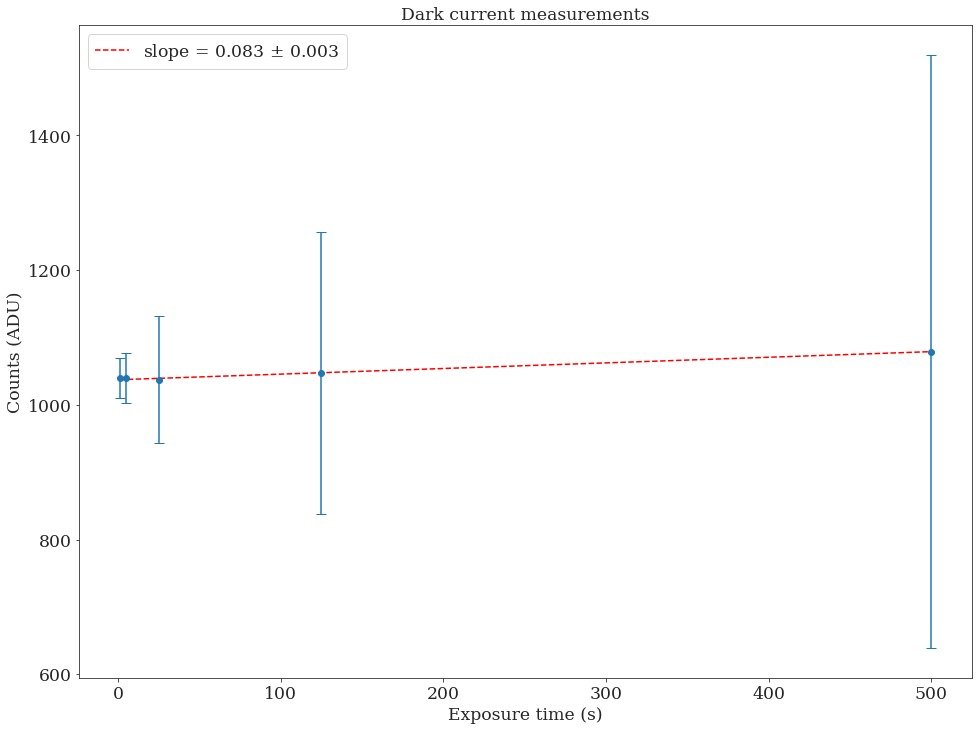

In [833]:
# plot dark current
plt.errorbar(exposure, darks, yerr=darks_std, fmt='o')
plt.plot(exposure, b + exposure_fit, '--r')
plt.xlabel("Exposure time (s)")
plt.ylabel("Counts (ADU)")
plt.title("Dark current measurements")

plt.legend(["slope = 0.083 $\pm$ 0.003",
           ])
plt.savefig('dark_current.png')

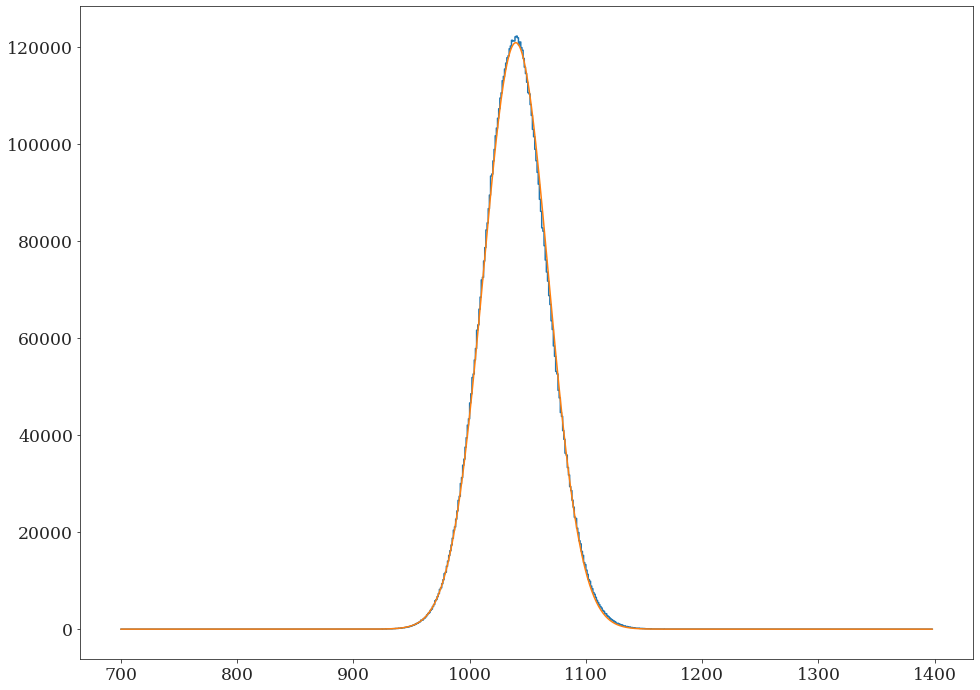

In [520]:
counts, bins = np.histogram(1.0*dark_1s.ravel(), bins=np.arange(700, 1400, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_1s),np.std(dark_1s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
mu_1s, sigma_1s = popt[1], popt[2]
plt.plot(bins[:-1], fit, label="1-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_1s/10.0))*10, (np.ceil(sigma_1s/10.0))*10))


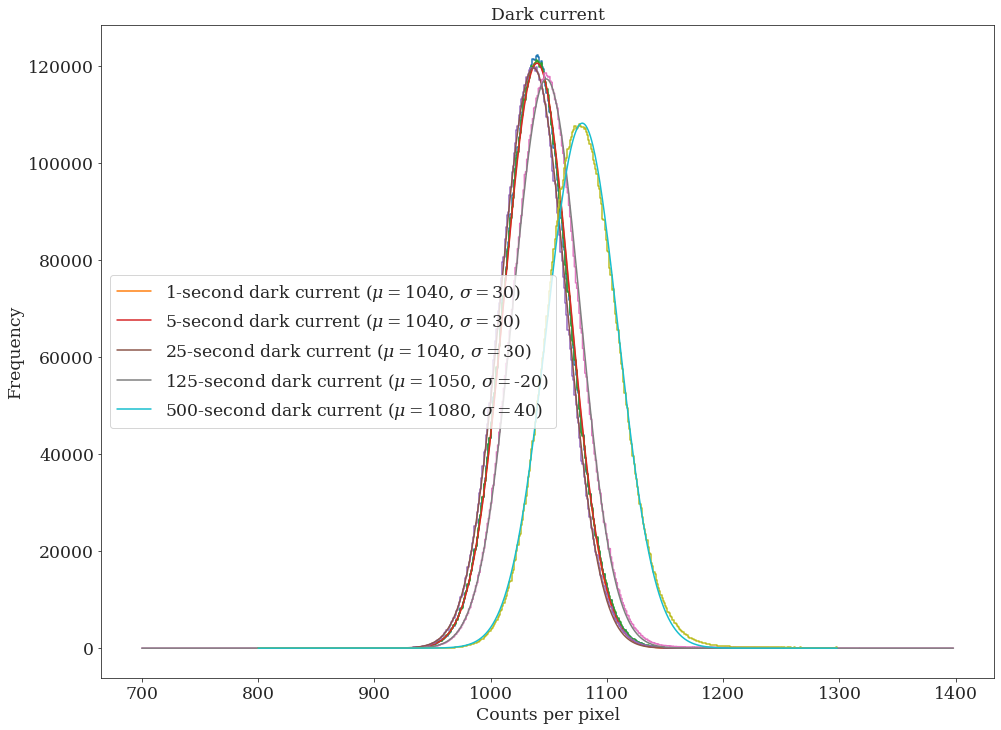

In [576]:
counts, bins = np.histogram(1.0*dark_1s.ravel(), bins=np.arange(800, 1300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_1s),np.std(dark_1s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="1-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_1s/10.0))*10, (np.ceil(sigma_1s/10.0))*10))
mu_1s, sigma_1s = popt[1], popt[2]

counts, bins = np.histogram(1.0*dark_5s.ravel(), bins=np.arange(800, 1300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_5s),np.std(dark_5s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="5-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_5s/10.0))*10, (np.ceil(sigma_5s/10.0))*10))
mu_5s, sigma_5s = popt[1], popt[2]

counts, bins = np.histogram(1.0*dark_25s.ravel(), bins=np.arange(800, 1300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_25s),np.std(dark_25s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="25-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_25s/10.0))*10, (np.ceil(sigma_25s/10.0))*10))
mu_25s, sigma_25s = popt[1], popt[2]

counts, bins = np.histogram(1.0*dark_125s.ravel(), bins=np.arange(700, 1400, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_125s),np.std(dark_125s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="125-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_125s/10.0))*10, (np.ceil(sigma_125s/10.0))*10))
mu_125s, sigma_125s = popt[1], popt[2]

counts, bins = np.histogram(1.0*dark_500s.ravel(), bins=np.arange(800, 1300, 1))
plt.step(bins[:-1], counts, label='_Hidden label')
def gauss(x, a, mu, sigma):
    return a*np.exp(-0.5*(x-mu)**2/(sigma**2))
popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=counts, p0=[1.,np.mean(dark_500s),np.std(dark_500s)]) # p0 = best guess
fit = gauss(bins[:-1], *popt)
plt.plot(bins[:-1], fit, label="500-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_500s/10.0))*10, (np.ceil(sigma_500s/10.0))*10))
mu_500s, sigma_500s = popt[1], popt[2]

plt.title('Dark current')
plt.xlabel("Counts per pixel")
plt.ylabel("Frequency")
plt.legend() #["1-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_1s/10.0))*10, (np.ceil(sigma_1s/10.0))*10), # rounding to nearest 10
            #"5-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_5s/10.0))*10, (np.ceil(sigma_5s/10.0))*10),
            #"25-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_25s/10.0))*10, (np.ceil(sigma_25s/10.0))*10),
            #"125-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_125s/10.0))*10, (np.ceil(sigma_125s/10.0))*10),
            #"500-second dark current ($\mu=${0:.0f}, $\sigma=${1:.0f})".format((np.ceil(mu_500s/10.0))*10, (np.ceil(sigma_500s/10.0))*10)])
plt.savefig('dark_current_hist.png')

In [588]:
exposure

[1, 5, 25, 125, 500]

[0.00529079 1.22095924]
0.08126423124129235 1037.9909262114024


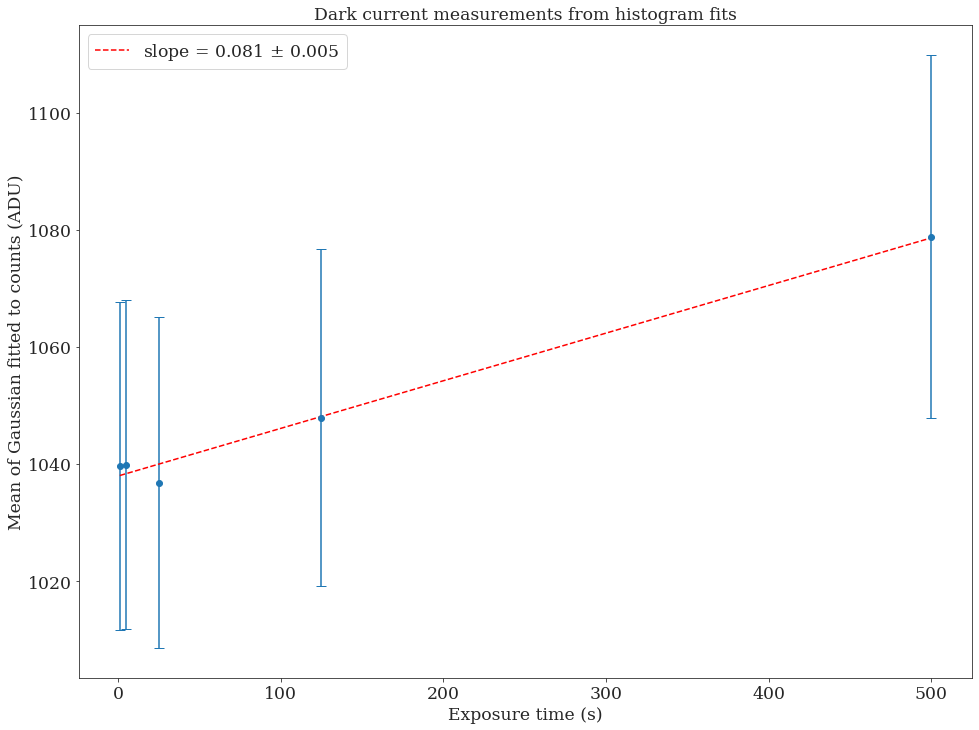

In [835]:
# do a linear fit to the histogram data
exposure = [1,5,25,125,500]
binned_darks = [mu_1s,mu_5s,mu_25s,mu_125s,mu_500s]
binned_darks_std = [sigma_1s, sigma_5s, sigma_25s, sigma_125s, sigma_500s]
[m, b], cov = np.polyfit(exposure, binned_darks, 1, cov=True)
exposure_fit = [i * m for i in exposure]
print(np.sqrt(np.diag(cov))) # this is the error on the slope and intercept
print(m,b)

# plot the fit
plt.plot(exposure, exposure_fit + b, '--r', label="slope = 0.081 $\pm$ 0.005")
plt.errorbar(exposure, binned_darks, yerr=binned_darks_std, fmt='o')
plt.legend()
plt.xlabel("Exposure time (s)")
plt.ylabel("Mean of Gaussian fitted to counts (ADU)")
plt.title("Dark current measurements from histogram fits")
plt.savefig('dark_current_binned.png')

#plt.plot(exposure, b + exposure_fit, '-')
#plt.xlabel("Exposure time (s)")
#plt.ylabel("Counts (ADU)")
#plt.legend(["slope = 0.08 $\pm$ ",

In [589]:
slope, intercept, r_value, p_value, std_err = stats.linregress(exposure, binned_darks)
print('slope = ', slope)
print('intercept = ', intercept)
print('correlation coefficient r =', r_value)

slope =  0.08126423124129234
intercept =  1037.9909262114031
correlation coefficient r = 0.993701825731005


## Measuring the gain / conversion from ADU to electrons

In [645]:
file_names = glob('day2/gain/01/*.fits')
lights_01s = []
for i in range(len(file_names)):
    lights_01s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/1/*.fits')
lights_1s = []
for i in range(len(file_names)):
    lights_1s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/5/*.fits')
lights_5s = []
for i in range(len(file_names)):
    lights_5s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/15/*.fits')
lights_15s = []
for i in range(len(file_names)):
    lights_15s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/25/*.fits')
lights_25s = []
for i in range(len(file_names)):
    lights_25s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/50/*.fits')
lights_50s = []
for i in range(len(file_names)):
    lights_50s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/75/*.fits')
lights_75s = []
for i in range(len(file_names)):
    lights_75s.append(fits.getdata(file_names[i]))

file_names = glob('day2/gain/100/*.fits')
lights_100s = []
for i in range(len(file_names)):
    lights_100s.append(fits.getdata(file_names[i]))

In [648]:
lights_01s = np.array(lights_01s)
lights_1s = np.array(lights_1s)
lights_5s = np.array(lights_5s)
lights_15s = np.array(lights_15s)
lights_25s = np.array(lights_25s)
lights_50s = np.array(lights_50s)
lights_75s = np.array(lights_75s)
lights_100s = np.array(lights_100s)

In [660]:
mean_01s = np.median(lights_01s, axis=0)
mean_1s = np.median(lights_1s, axis=0)
mean_5s = np.median(lights_5s, axis=0)
mean_15s = np.median(lights_15s, axis=0)
mean_25s = np.median(lights_25s, axis=0)
mean_50s = np.median(lights_50s, axis=0)
mean_75s = np.median(lights_75s, axis=0)
mean_100s = np.median(lights_100s, axis=0)

std_01s = np.std(lights_01s, axis=0) 
std_1s = np.std(lights_1s, axis=0)
std_5s = np.std(lights_5s, axis=0)
std_15s = np.std(lights_15s, axis=0) 
std_25s = np.std(lights_25s, axis=0) 
std_50s = np.std(lights_50s, axis=0) 
std_75s = np.std(lights_75s, axis=0) 
std_100s = np.std(lights_100s, axis=0)

In [719]:
lights_std

[25.368396787253932,
 28.296053906272277,
 55.61974070018267,
 88.13751881135651,
 111.18453129819814,
 213.8680797958301,
 289.0863000712571]

In [706]:
lights = []
lights.append(np.median(mean_01s))
lights.append(np.median(mean_1s))
lights.append(np.median(mean_5s))
lights.append(np.median(mean_15s))
lights.append(np.median(mean_25s))
#lights.append(np.median(mean_50s))
lights.append(np.median(mean_75s))
lights.append(np.median(mean_100s))

lights_std = []
lights_std.append(np.median(std_01s))
lights_std.append(np.median(std_1s))
lights_std.append(np.median(std_5s))
lights_std.append(np.median(std_15s))
lights_std.append(np.median(std_25s))
#lights_std.append(np.median(std_50s))
lights_std.append(np.median(std_75s))
lights_std.append(np.median(std_100s))

lights_cov = []
lights_cov.append(np.median(std_01s**2))
lights_cov.append(np.median(std_1s**2))
lights_cov.append(np.median(std_5s**2))
lights_cov.append(np.median(std_15s**2))
lights_cov.append(np.median(std_25s**2))
#lights_cov.append(np.median(std_50s**2))
lights_cov.append(np.median(std_75s**2))
lights_cov.append(np.median(std_100s**2))

In [707]:
[m, b], cov = np.polyfit(lights[:7], lights_std[:7], 1, cov=True)
m, b
lights[:5]
lights_std

[25.368396787253932,
 28.296053906272277,
 55.61974070018267,
 88.13751881135651,
 111.18453129819814,
 213.8680797958301,
 289.0863000712571]

1.9914388175908944 -7782.350302755583
[2.03956881e-01 6.28737026e+03]


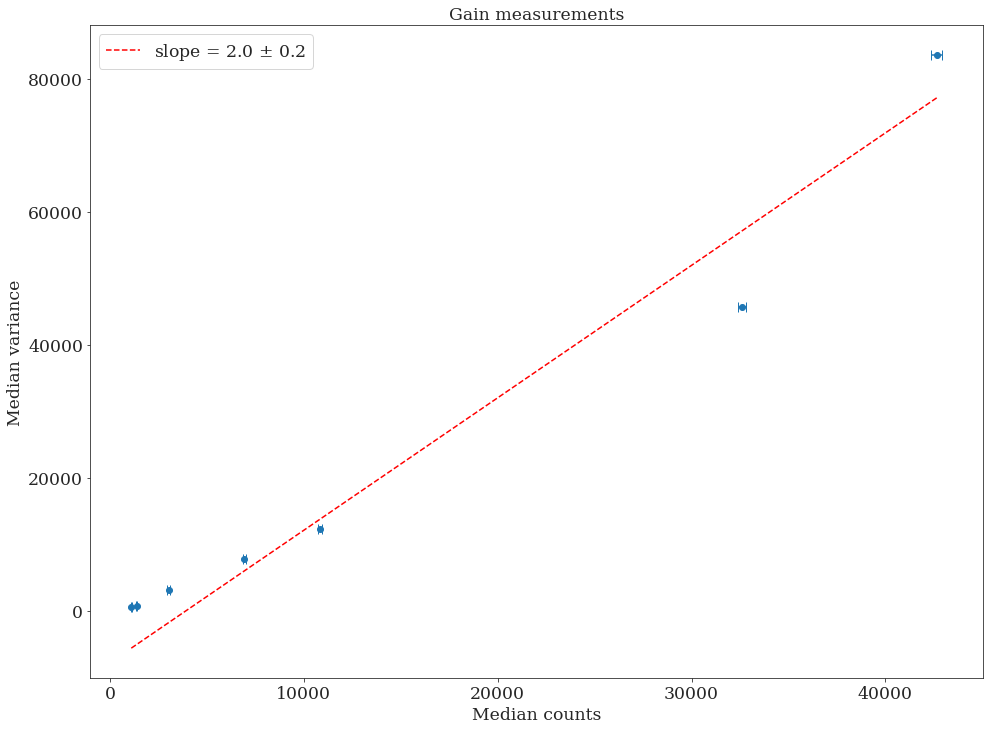

In [726]:
#plt.scatter(lights,lights_std,xerr=)
plt.errorbar(lights, lights_cov, xerr=lights_std, fmt='o')
plt.title("")
plt.xlabel("Median counts")
plt.ylabel("Median variance")

# do a linear fit to the histogram data
[m, b], cov = np.polyfit(lights, lights_cov, 1, w=np.sqrt(lights_std), cov=True)
exposure_fit = [i * m for i in lights]
print(m, b)
print(np.sqrt(np.diag(cov))) # this is the error on the slope and intercept

# plot the fit
plt.plot(lights, exposure_fit + b, '--r', label="slope = 2.0 $\pm$ 0.2")
plt.legend()
plt.title("Gain measurements")
plt.savefig('gain.png')


## Linearity and saturation

In [814]:
# brighter version
# frames: 1s, 3s, 10s, 30s, 60s, 120s, 180s (~saturated)
lin_amb_files = glob('day2/lin_amb*.fits')
lin_amb_images = []
for i in range(len(lin_amb_files)):
    lin_amb_images.append(fits.getdata(lin_amb_files[i]))
lin_amb_image_array = np.array(lin_amb_images)
exposure_amb=[1,3,10,30,60,120,180]

# faint version
# frames: 1s, 3s, 10s, 30s, 60s, 120s, 180s, 240s, 300s
lin_dim_files = glob('day2/lin_dim*.fits')
lin_dim_images = []
for i in range(len(lin_dim_files)):
    lin_dim_images.append(fits.getdata(lin_dim_files[i]))
lin_dim_image_array = np.array(lin_dim_images)
exposure_dim=[1,3,10,30,60,120,180,240,300]

### Brighter conditions

In [815]:
# brighter ones
lin_amb_medians=[]
lin_amb_medians.append(np.median(lin_amb_image_array[6]))
lin_amb_medians.append(np.median(lin_amb_image_array[4]))
lin_amb_medians.append(np.median(lin_amb_image_array[0]))
lin_amb_medians.append(np.median(lin_amb_image_array[3]))
lin_amb_medians.append(np.median(lin_amb_image_array[5]))
lin_amb_medians.append(np.median(lin_amb_image_array[2]))
lin_amb_medians.append(np.median(lin_amb_image_array[1]))

lin_amb_std=[]
lin_amb_std.append(np.std(lin_amb_image_array[6]))
lin_amb_std.append(np.std(lin_amb_image_array[4]))
lin_amb_std.append(np.std(lin_amb_image_array[0]))
lin_amb_std.append(np.std(lin_amb_image_array[3]))
lin_amb_std.append(np.std(lin_amb_image_array[5]))
lin_amb_std.append(np.std(lin_amb_image_array[2]))
lin_amb_std.append(np.std(lin_amb_image_array[1]))

In [827]:
# do a linear fit weighted by stds
[m, b], cov = np.polyfit(exposure_amb[:6], lin_amb_medians[:6], 1, w=np.sqrt(lin_amb_std[:6]), cov=True)
exposure_fit = [i * m for i in exposure_amb[:6]]
print(np.sqrt(np.diag(cov))) # this is the std on the slope and intercept
print(m,b)

# do a linear fit weighted by stds
[m2, b2], cov2 = np.polyfit(exposure_amb[:5], lin_amb_medians[:5], 1, w=np.sqrt(lin_amb_std[:5]), cov=True)
exposure_fit2 = [i * m for i in exposure_amb[:5]]
print(np.sqrt(np.diag(cov2))) # this is the std on the slope and intercept
print(m2,b2)

[  1.85396711 173.00067797]
436.39543163872116 1397.4245695675627
[ 1.20392191 58.00276723]
446.53581958057765 1004.9416536814146


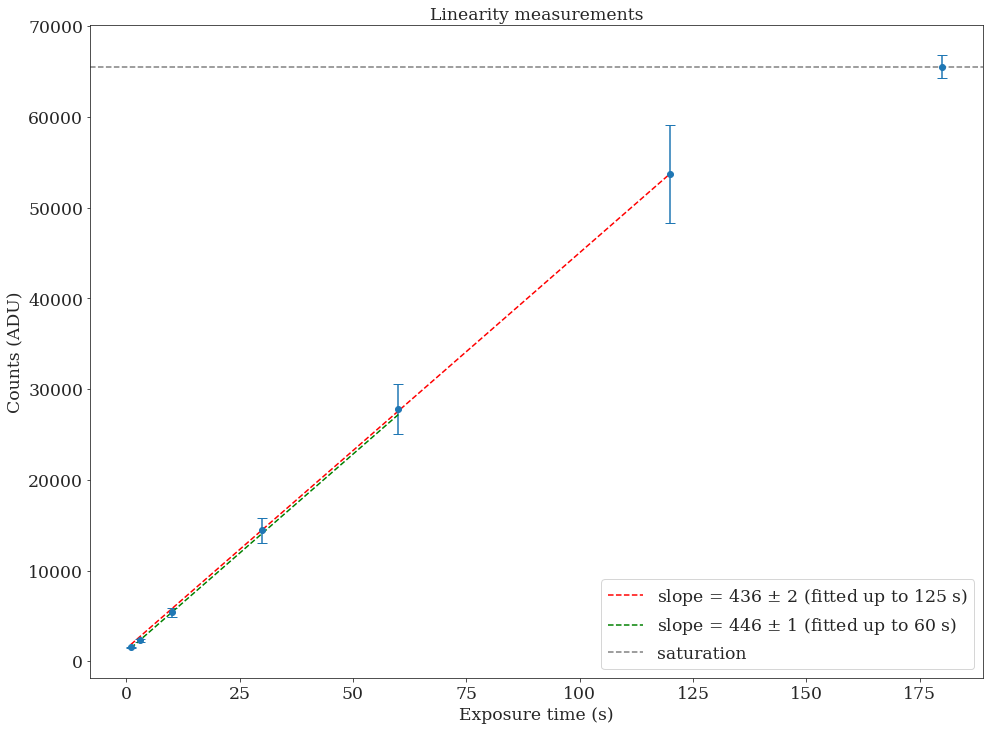

In [829]:
# plot linearity data
plt.errorbar(exposure_amb, lin_amb_medians, yerr=lin_amb_std, fmt='o')
plt.plot(exposure_amb[:6], b + exposure_fit, '--r')
plt.plot(exposure_amb[:5], b2 + exposure_fit2, '--g')
plt.axhline(y=65535, color='gray', linestyle='--')
plt.xlabel("Exposure time (s)")
plt.ylabel("Counts (ADU)")
plt.title("Linearity measurements")

plt.legend(["slope = 436 $\pm$ 2 (fitted up to 125 s)",
            "slope = 446 $\pm$ 1 (fitted up to 60 s)",
            "saturation"
           ])
plt.savefig('linearity_bright.png')

### Dimmer conditions

In [825]:
# dimmer ones
lin_dim_medians=[]
lin_dim_medians.append(np.median(lin_dim_image_array[6]))
lin_dim_medians.append(np.median(lin_dim_image_array[5]))
lin_dim_medians.append(np.median(lin_dim_image_array[2]))
lin_dim_medians.append(np.median(lin_dim_image_array[4]))
lin_dim_medians.append(np.median(lin_dim_image_array[0]))
lin_dim_medians.append(np.median(lin_dim_image_array[7]))
lin_dim_medians.append(np.median(lin_dim_image_array[8]))
lin_dim_medians.append(np.median(lin_dim_image_array[3]))
lin_dim_medians.append(np.median(lin_dim_image_array[1]))

lin_dim_std=[]
lin_dim_std.append(np.std(lin_dim_image_array[6]))
lin_dim_std.append(np.std(lin_dim_image_array[5]))
lin_dim_std.append(np.std(lin_dim_image_array[2]))
lin_dim_std.append(np.std(lin_dim_image_array[4]))
lin_dim_std.append(np.std(lin_dim_image_array[0]))
lin_dim_std.append(np.std(lin_dim_image_array[7]))
lin_dim_std.append(np.std(lin_dim_image_array[8]))
lin_dim_std.append(np.std(lin_dim_image_array[3]))
lin_dim_std.append(np.std(lin_dim_image_array[1]))

# do a linear fit weighted by stds
[m, b], cov = np.polyfit(exposure_dim, lin_dim_medians, 1, w=np.sqrt(lin_dim_std), cov=True)
exposure_fit = [i * m for i in exposure_dim]
print(np.sqrt(np.diag(cov))) # this is the std on the slope and intercept
print(m,b)

[ 0.20860242 47.16992512]
64.19615434624075 916.321572259355


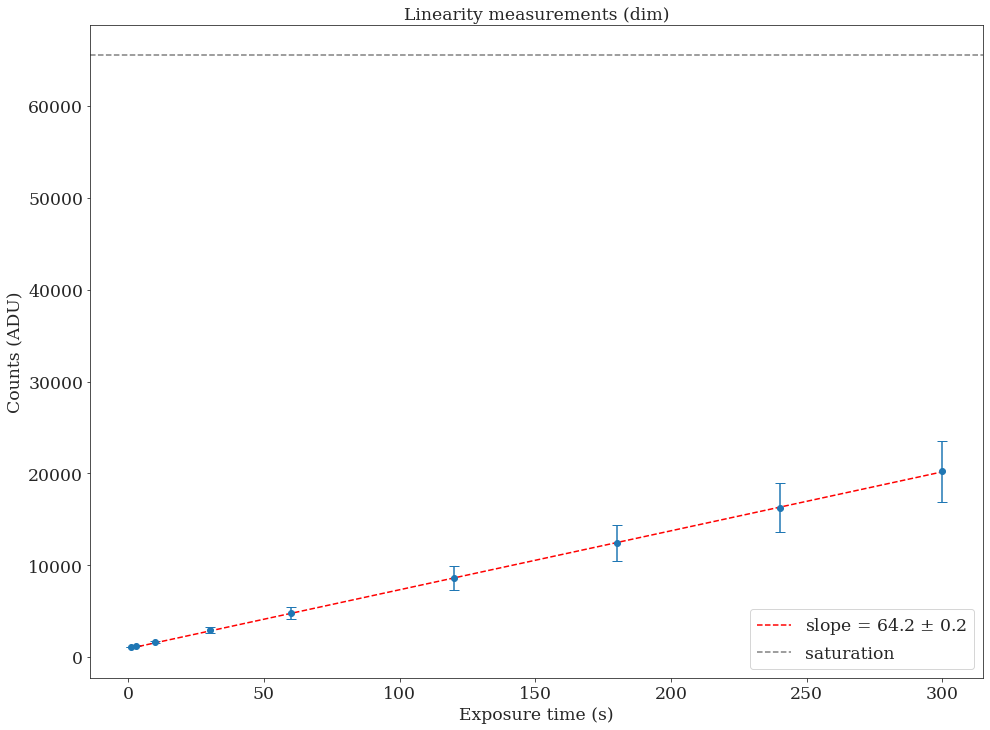

In [826]:
# plot linearity data
plt.errorbar(exposure_dim, lin_dim_medians, yerr=lin_dim_std, fmt='o')
plt.plot(exposure_dim, b + exposure_fit, '--r')
plt.axhline(y=65535, color='gray', linestyle='--')
plt.xlabel("Exposure time (s)")
plt.ylabel("Counts (ADU)")
plt.title("Linearity measurements (dim)")

plt.legend(["slope = 64.2 $\pm$ 0.2",
            "saturation"
           ])
plt.savefig('linearity_dim.png')

In [822]:
np.max(lin_dim_medians)

20218.0